In [ ]:
import json
import os
import pandas as pd
import librosa
import numpy as np
from IPython.display import Audio
import librosa
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive/523FinalProject/datasets"
json_path = os.path.join(base_dir, "examples.json")
audio_dir = os.path.join(base_dir, "audio")

# Load the whole file as one big JSON object
with open(json_path, "r") as f:
    data_dict = json.load(f)

data = []
for note_str, features in data_dict.items():
    features["note_str"] = note_str
    data.append(features)
df = pd.DataFrame(data)
df["audio_path"] = df["note_str"].apply(lambda x: os.path.join(audio_dir, x + ".wav"))

print("✅ Loaded", len(df), "examples")


✅ Loaded 2000 examples


In [ ]:
src_family = "string"   # violin
tgt_family = "brass"    # trumpet

subset = df[
    df["instrument_family_str"].isin([src_family, tgt_family]) &
    df["instrument_source_str"].isin(["acoustic"])
].copy()

match_cols = ["pitch", "velocity", "sample_rate"]

pairs = []

# group in same attributes
for key, group in subset.groupby(match_cols):

    src_group = group[group["instrument_family_str"] == src_family]
    tgt_group = group[group["instrument_family_str"] == tgt_family]

    if len(src_group) == 0 or len(tgt_group) == 0:
        continue

    # pair
    for _, src_row in src_group.iterrows():
        for _, tgt_row in tgt_group.iterrows():

            pairs.append({
                # pitch / velocity / sample_rate
                **{col: src_row[col] for col in match_cols},

                # audio_path
                "src_audio": src_row["audio_path"],
                "tgt_audio": tgt_row["audio_path"],

                # instrument_str
                "src_inst": src_row["instrument_str"],
                "tgt_inst": tgt_row["instrument_str"],

                # note_str
                "src_note": src_row["note_str"],
                "tgt_note": tgt_row["note_str"],

                # source
                "src_source": src_row["instrument_source_str"],
                "tgt_source": tgt_row["instrument_source_str"],

                # qualities
                "src_qualities": src_row["qualities_str"],
                "tgt_qualities": tgt_row["qualities_str"],
            })

pairs_df = pd.DataFrame(pairs)
print(f"✅ Created {len(pairs_df)} violin–trumpet pairs")
pairs_df.head()


✅ Created 14922 violin–trumpet pairs


,pitch,velocity,sample_rate,src_audio,tgt_audio,src_inst,tgt_inst,src_note,tgt_note,src_source,tgt_source,src_qualities,tgt_qualities
0,60,25,16000,/content/drive/MyDrive/523FinalProject/dataset...,/content/drive/MyDrive/523FinalProject/dataset...,string_acoustic_049,brass_acoustic_028,string_acoustic_049-060-025,brass_acoustic_028-060-025,acoustic,acoustic,[reverb],[reverb]
1,60,25,16000,/content/drive/MyDrive/523FinalProject/dataset...,/content/drive/MyDrive/523FinalProject/dataset...,string_acoustic_049,brass_acoustic_038,string_acoustic_049-060-025,brass_acoustic_038-060-025,acoustic,acoustic,[reverb],[]
2,60,25,16000,/content/drive/MyDrive/523FinalProject/dataset...,/content/drive/MyDrive/523FinalProject/dataset...,string_acoustic_049,brass_acoustic_052,string_acoustic_049-060-025,brass_acoustic_052-060-025,acoustic,acoustic,[reverb],[]
3,60,25,16000,/content/drive/MyDrive/523FinalProject/dataset...,/content/drive/MyDrive/523FinalProject/dataset...,string_acoustic_049,brass_acoustic_000,string_acoustic_049-060-025,brass_acoustic_000-060-025,acoustic,acoustic,[reverb],"[dark, reverb]"
4,60,25,16000,/content/drive/MyDrive/523FinalProject/dataset...,/content/drive/MyDrive/523FinalProject/dataset...,string_acoustic_049,brass_acoustic_062,string_acoustic_049-060-025,brass_acoustic_062-060-025,acoustic,acoustic,[reverb],"[dark, long_release, reverb]"


In [ ]:
from IPython.display import Audio, display

# random pick a violin→trumpet pair
sample = pairs_df.sample(1).iloc[0]

print("🎻 Violin (source):", sample["src_audio"])
display(Audio(filename=sample["src_audio"], rate=16000))

print("🎺 Trumpet (target):", sample["tgt_audio"])
display(Audio(filename=sample["tgt_audio"], rate=16000))

print(sample)

🎻 Violin (source): /content/drive/MyDrive/523FinalProject/datasets/audio/string_acoustic_048-068-127.wav


🎺 Trumpet (target): /content/drive/MyDrive/523FinalProject/datasets/audio/brass_acoustic_047-068-127.wav


pitch                                                           68
velocity                                                       127
sample_rate                                                  16000
src_audio        /content/drive/MyDrive/523FinalProject/dataset...
tgt_audio        /content/drive/MyDrive/523FinalProject/dataset...
src_inst                                       string_acoustic_048
tgt_inst                                        brass_acoustic_047
src_note                               string_acoustic_048-068-127
tgt_note                                brass_acoustic_047-068-127
src_source                                                acoustic
tgt_source                                                acoustic
src_qualities                               [long_release, reverb]
tgt_qualities                                 [bright, distortion]
src_mel_path                    precomputed_mels/src/10625_src.npy
tgt_mel_path                    precomputed_mels/tgt/10625_tgt

In [ ]:
class ViolinTrumpetMelDataset(Dataset):
    """
    Directly load the Mel from pre-saved .npy files.
    The expected DataFrame should contain: ['src_mel_path', 'tgt_mel_path']
    """
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        src_mel = np.load(row["src_mel_path"])  # (n_mels, T_new)
        tgt_mel = np.load(row["tgt_mel_path"])

        src_mel = torch.from_numpy(src_mel).unsqueeze(0)  # (1, n_mels, T_new)
        tgt_mel = torch.from_numpy(tgt_mel).unsqueeze(0)

        return src_mel.float(), tgt_mel.float()

In [ ]:
import os
import numpy as np
import librosa
from tqdm.auto import tqdm
import pandas as pd

# ========================================
# only take the first 0.5 seconds
# ========================================

sr = 16000
duration = 0.5
n_fft = 1024
hop_length = 128
n_mels = 128

num_samples = int(sr * duration)  # 8000 samples

def audio_to_mel_db(y, sr=sr):
    """take 0.5 mel dB（cut or fill to 0.5s）"""
    if len(y) > num_samples:
        y = y[:num_samples]
    else:
        y = np.pad(y, (0, num_samples - len(y)))

    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, power=2.0
    )
    mel_db = librosa.power_to_db(S, ref=np.max)
    return mel_db.astype(np.float32)

def extract_first_05s_segment(audio_path):
    """
    only take the first 0.5 seconds

    return:
        mel (128, ~63) or None
    """
    y, _ = librosa.load(audio_path, sr=sr)

    # take the first 0.5 seconds
    first_05s = y[:num_samples]

    # volume check
    if len(first_05s) == 0:
        return None
    energy = np.sqrt(np.mean(first_05s ** 2))
    if energy < 0.01:
        return None

    mel = audio_to_mel_db(first_05s)
    return mel

# ========================================
# Preprocess the entire dataset: generate only one 0.5-second segment for each audio pair
# ========================================
print("Extracting first 0.5s segment from each audio...")

mel_root = "precomputed_mels_0.5s_first_half"
os.makedirs(os.path.join(mel_root, "src"), exist_ok=True)
os.makedirs(os.path.join(mel_root, "tgt"), exist_ok=True)

new_pairs = []
skipped = 0

for idx, row in tqdm(pairs_df.iterrows(), total=len(pairs_df), desc="Processing"):

    src_mel = extract_first_05s_segment(row["src_audio"])
    tgt_mel = extract_first_05s_segment(row["tgt_audio"])

    if src_mel is None or tgt_mel is None:
        skipped += 1
        continue

    # generate one sample for each original_idx
    pair_id = f"{idx}"

    src_path = os.path.join(mel_root, "src", f"{pair_id}.npy")
    tgt_path = os.path.join(mel_root, "tgt", f"{pair_id}.npy")

    np.save(src_path, src_mel)
    np.save(tgt_path, tgt_mel)

    new_pairs.append({
        "original_idx": idx,
        "segment_idx": 0,
        "time_range": "0.0-0.5s",
        "src_mel_path": src_path,
        "tgt_mel_path": tgt_path,
        "pitch": row["pitch"],
        "velocity": row["velocity"],
        "src_inst": row["src_inst"],
        "tgt_inst": row["tgt_inst"],
    })

# New DataFrame
pairs_05s_df = pd.DataFrame(new_pairs)

print(f"\n✅ Original pairs: {len(pairs_df)}")
print(f"✅ New 0.5s segments: {len(pairs_05s_df)}")
print(f"✅ Skipped (too quiet): {skipped}")
print(f"✅ Expansion ratio: {len(pairs_05s_df) / len(pairs_df):.1f}x")

# shape check
sample_mel = np.load(pairs_05s_df.iloc[0]["src_mel_path"])
print(f"\nMel shape: {sample_mel.shape}")
print(f"Expected: (128, ~63) for 0.5s audio")

print("\n📋 Sample data:")
print(pairs_05s_df.head())

🔄 Extracting first 0.5s segment from each audio...


Processing:   0%|          | 0/14922 [00:00<?, ?it/s]


✅ Original pairs: 14922
✅ New 0.5s segments: 14922
✅ Skipped (too quiet): 0
✅ Expansion ratio: 1.0x

Mel shape: (128, 63)
Expected: (128, ~63) for 0.5s audio

📋 Sample data:
   original_idx  segment_idx time_range  \
0             0            0   0.0-0.5s   
1             1            0   0.0-0.5s   
2             2            0   0.0-0.5s   
3             3            0   0.0-0.5s   
4             4            0   0.0-0.5s   

                                 src_mel_path  \
0  precomputed_mels_0.5s_first_half/src/0.npy   
1  precomputed_mels_0.5s_first_half/src/1.npy   
2  precomputed_mels_0.5s_first_half/src/2.npy   
3  precomputed_mels_0.5s_first_half/src/3.npy   
4  precomputed_mels_0.5s_first_half/src/4.npy   

                                 tgt_mel_path  pitch  velocity  \
0  precomputed_mels_0.5s_first_half/tgt/0.npy     60        25   
1  precomputed_mels_0.5s_first_half/tgt/1.npy     60        25   
2  precomputed_mels_0.5s_first_half/tgt/2.npy     60        25   
3  prec

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

groups = pairs_05s_df["original_idx"].values
gss = GroupShuffleSplit(test_size=0.1, n_splits=1, random_state=42)

train_idx, val_idx = next(gss.split(pairs_05s_df, groups=groups))
train_df = pairs_05s_df.iloc[train_idx].reset_index(drop=True)
val_df   = pairs_05s_df.iloc[val_idx].reset_index(drop=True)

print(len(train_df), len(val_df))

13429 1493


In [ ]:
import numpy as np

def compute_mel_mean_std(df):
    all_mels = []
    for _, row in df.iterrows():
        src = np.load(row["src_mel_path"]).astype(np.float32)  # (128, 63)
        tgt = np.load(row["tgt_mel_path"]).astype(np.float32)
        all_mels.append(src)
        all_mels.append(tgt)
    stacked = np.stack(all_mels, axis=0)  # (2N, 128, 63)
    mean = stacked.mean()
    std = stacked.std()
    return float(mean), float(std)

mel_mean, mel_std = compute_mel_mean_std(train_df)
print("mel_mean:", mel_mean, "mel_std:", mel_std)

mel_mean: -51.141639709472656 mel_std: 18.99280548095703


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MelPairsDataset(Dataset):
    def __init__(self, df, mel_mean, mel_std):
        self.df = df.reset_index(drop=True)
        self.mel_mean = mel_mean
        self.mel_std = mel_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        src = np.load(row["src_mel_path"]).astype(np.float32)  # (128, 63)
        tgt = np.load(row["tgt_mel_path"]).astype(np.float32)

        # Standardize
        src = (src - self.mel_mean) / (self.mel_std + 1e-8)
        tgt = (tgt - self.mel_mean) / (self.mel_std + 1e-8)

        # [C, H, W]
        src = torch.from_numpy(src).unsqueeze(0)  # [1, 128, 63]
        tgt = torch.from_numpy(tgt).unsqueeze(0)

        return {
            "src": src,
            "tgt": tgt,
            "pitch": row["pitch"],
            "velocity": row["velocity"],
            "src_inst": row["src_inst"],
            "tgt_inst": row["tgt_inst"],
        }

batch_size = 32

train_dataset = MelPairsDataset(train_df, mel_mean, mel_std)
val_dataset   = MelPairsDataset(val_df,   mel_mean, mel_std)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
all_insts = sorted(set(pairs_05s_df["src_inst"]) | set(pairs_05s_df["tgt_inst"]))
inst2id = {name: i for i, name in enumerate(all_insts)}
num_instruments = len(all_insts)

print("num_instruments =", num_instruments)
print(list(inst2id.items())[:10])

num_instruments = 141
[('brass_acoustic_000', 0), ('brass_acoustic_001', 1), ('brass_acoustic_002', 2), ('brass_acoustic_003', 3), ('brass_acoustic_004', 4), ('brass_acoustic_005', 5), ('brass_acoustic_007', 6), ('brass_acoustic_008', 7), ('brass_acoustic_009', 8), ('brass_acoustic_010', 9)]


In [ ]:
import torch
from torch.utils.data import Dataset

class MelPairsCondDataset(Dataset):
    def __init__(self, df, mel_mean, mel_std, inst2id):
        self.df = df.reset_index(drop=True)
        self.mel_mean = mel_mean
        self.mel_std = mel_std
        self.inst2id = inst2id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        src = np.load(row["src_mel_path"]).astype(np.float32)  # (128, 63)
        tgt = np.load(row["tgt_mel_path"]).astype(np.float32)

        # === standardize mel ===
        src = (src - self.mel_mean) / (self.mel_std + 1e-8)
        tgt = (tgt - self.mel_mean) / (self.mel_std + 1e-8)

        # [1, H, W]
        src = torch.from_numpy(src).unsqueeze(0)
        tgt = torch.from_numpy(tgt).unsqueeze(0)

        # === pitch / velocity ===
        pitch = float(row["pitch"])
        velocity = float(row["velocity"])

        # Simple normalization to [0, 1], assuming MIDI pitch/velocity ≤ 127
        pitch_norm = torch.tensor(pitch / 127.0, dtype=torch.float32)
        vel_norm   = torch.tensor(velocity / 127.0, dtype=torch.float32)

        # === inst id ===
        src_inst_id = torch.tensor(self.inst2id[row["src_inst"]], dtype=torch.long)
        tgt_inst_id = torch.tensor(self.inst2id[row["tgt_inst"]], dtype=torch.long)

        return {
            "src": src,            # [1, 128, 63]
            "tgt": tgt,            # [1, 128, 63]
            "pitch": pitch_norm,
            "velocity": vel_norm,
            "src_inst_id": src_inst_id,
            "tgt_inst_id": tgt_inst_id,
        }

In [ ]:
batch_size = 32

train_dataset = MelPairsCondDataset(train_df, mel_mean, mel_std, inst2id)
val_dataset   = MelPairsCondDataset(val_df,   mel_mean, mel_std, inst2id)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class CondUNetRF(nn.Module):
    def __init__(
        self,
        num_instruments,
        cond_channels=16,
        base_channels=64,
    ):
        super().__init__()
        self.cond_channels = cond_channels

        # ===== Conditioning encoding section =====
        emb_dim_inst = 8
        emb_dim_pitch_vel = 8

        self.inst_embedding = nn.Embedding(num_instruments, emb_dim_inst)

        self.pitch_vel_mlp = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, emb_dim_pitch_vel),
            nn.ReLU(),
        )

        # src_inst (8) + tgt_inst (8) + pitch_vel (8) = 24 -> cond_channels
        self.cond_fc = nn.Linear(emb_dim_inst * 2 + emb_dim_pitch_vel, cond_channels)

        # ===== UNet encoder (downsampling only along the frequency axis) =====
        in_channels = 1 + 1 + 1 + cond_channels  # z_t + src + t + cond_map

        self.enc1 = ConvBlock(in_channels, base_channels)      # H:128, W:63
        self.down1 = nn.Conv2d(base_channels, base_channels, 3, stride=(2, 1), padding=1)  # H/2

        self.enc2 = ConvBlock(base_channels, base_channels * 2)  # H:64
        self.down2 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, stride=(2, 1), padding=1)  # H:32

        # bottleneck
        self.bottleneck = ConvBlock(base_channels * 2, base_channels * 4)  # H:32

        # ===== Decoder (upsampling back) =====
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2,
                                      kernel_size=(4, 3), stride=(2, 1), padding=(1, 1))
        self.dec2 = ConvBlock(base_channels * 4, base_channels * 2)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels,
                                      kernel_size=(4, 3), stride=(2, 1), padding=(1, 1))
        self.dec1 = ConvBlock(base_channels * 2, base_channels)

        # velocity field
        self.out_conv = nn.Conv2d(base_channels, 1, kernel_size=3, padding=1)

    def encode_cond(self, pitch, velocity, src_inst_id, tgt_inst_id):
        """
        pitch, velocity: [B] float
        src_inst_id, tgt_inst_id: [B] long
        返回 cond_vec: [B, cond_channels]
        """
        # pitch + velocity
        pv = torch.stack([pitch, velocity], dim=1)  # [B, 2]
        pv_emb = self.pitch_vel_mlp(pv)            # [B, 8]

        # instrument embeddings
        src_emb = self.inst_embedding(src_inst_id)  # [B, 8]
        tgt_emb = self.inst_embedding(tgt_inst_id)  # [B, 8]

        cond_vec = torch.cat([src_emb, tgt_emb, pv_emb], dim=1)  # [B, 24]
        cond_vec = self.cond_fc(cond_vec)                        # [B, cond_channels]
        return cond_vec

    def forward(self, z_t, src, t, pitch, velocity, src_inst_id, tgt_inst_id):
        """
        z_t: [B, 1, H, W]
        src: [B, 1, H, W]
        t:   [B] float
        pitch, velocity: [B] float
        src_inst_id, tgt_inst_id: [B] long
        """
        B, _, H, W = z_t.shape

        # ===== Time channels =====
        t = t.view(B, 1, 1, 1)
        t_channel = t.expand(B, 1, H, W)  # [B, 1, H, W]

        # ===== Conditioning channels =====
        cond_vec = self.encode_cond(pitch, velocity, src_inst_id, tgt_inst_id)  # [B, Cc]
        cond_map = cond_vec.view(B, self.cond_channels, 1, 1).expand(B, self.cond_channels, H, W)

        x = torch.cat([z_t, src, t_channel, cond_map], dim=1)   # [B, in_channels, H, W]

        # ===== UNet encoding =====
        e1 = self.enc1(x)           # [B, C, 128, 63]
        d1 = self.down1(e1)         # [B, C, 64, 63]

        e2 = self.enc2(d1)          # [B, 2C, 64, 63]
        d2 = self.down2(e2)         # [B, 2C, 32, 63]

        b = self.bottleneck(d2)     # [B, 4C, 32, 63]

        # ===== Decoding =====
        u2 = self.up2(b)            # [B, 2C, ~64, ~63]

        if u2.size(2) != e2.size(2):
            u2 = F.interpolate(u2, size=(e2.size(2), e2.size(3)), mode="bilinear", align_corners=False)

        u2 = torch.cat([u2, e2], dim=1)   # [B, 4C, 64, 63]
        u2 = self.dec2(u2)                # [B, 2C, 64, 63]

        u1 = self.up1(u2)                 # [B, C, ~128, ~63]
        if u1.size(2) != e1.size(2):
            u1 = F.interpolate(u1, size=(e1.size(2), e1.size(3)), mode="bilinear", align_corners=False)

        u1 = torch.cat([u1, e1], dim=1)   # [B, 2C, 128, 63]
        u1 = self.dec1(u1)                # [B, C, 128, 63]

        v = self.out_conv(u1)             # [B, 1, 128, 63]
        return v

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CondUNetRF(num_instruments=num_instruments, cond_channels=16, base_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import torch.nn.functional as F

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in loader:
        src = batch["src"].to(device)   # [B,1,H,W]
        tgt = batch["tgt"].to(device)   # [B,1,H,W]

        pitch    = batch["pitch"].to(device)        # [B]
        velocity = batch["velocity"].to(device)     # [B]
        src_inst = batch["src_inst_id"].to(device)  # [B]
        tgt_inst = batch["tgt_inst_id"].to(device)  # [B]

        B = src.size(0)
        x0 = torch.randn_like(tgt)
        t  = torch.rand(B, device=device)

        t_view = t.view(B, 1, 1, 1)
        z_t = (1.0 - t_view) * x0 + t_view * tgt
        v_target = tgt - x0

        v_pred = model(z_t, src, t, pitch, velocity, src_inst, tgt_inst)

        loss = F.mse_loss(v_pred, v_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, device):
    model.eval()
    total_loss = 0.0

    for batch in loader:
        src = batch["src"].to(device)
        tgt = batch["tgt"].to(device)

        pitch    = batch["pitch"].to(device)
        velocity = batch["velocity"].to(device)
        src_inst = batch["src_inst_id"].to(device)
        tgt_inst = batch["tgt_inst_id"].to(device)

        B = src.size(0)
        x0 = torch.randn_like(tgt)
        t  = torch.rand(B, device=device)

        t_view = t.view(B, 1, 1, 1)
        z_t = (1.0 - t_view) * x0 + t_view * tgt
        v_target = tgt - x0

        v_pred = model(z_t, src, t, pitch, velocity, src_inst, tgt_inst)
        loss = F.mse_loss(v_pred, v_target)

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)

In [ ]:
train_losses_hist = []
val_losses_hist = []

In [ ]:
num_epochs = 40

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss   = eval_one_epoch(model, val_loader, device)

    train_losses_hist.append(train_loss)
    val_losses_hist.append(val_loss)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

Epoch 01 | train_loss=0.199519 | val_loss=0.196419
Epoch 02 | train_loss=0.196953 | val_loss=0.194707
Epoch 03 | train_loss=0.201420 | val_loss=0.200017
Epoch 04 | train_loss=0.197601 | val_loss=0.191768
Epoch 05 | train_loss=0.197661 | val_loss=0.199838
Epoch 06 | train_loss=0.197273 | val_loss=0.198516
Epoch 07 | train_loss=0.196160 | val_loss=0.193356
Epoch 08 | train_loss=0.195858 | val_loss=0.198179
Epoch 09 | train_loss=0.194047 | val_loss=0.187387
Epoch 10 | train_loss=0.193366 | val_loss=0.195297
Epoch 11 | train_loss=0.189909 | val_loss=0.189580
Epoch 12 | train_loss=0.193762 | val_loss=0.192101
Epoch 13 | train_loss=0.191740 | val_loss=0.188493
Epoch 14 | train_loss=0.189813 | val_loss=0.183868
Epoch 15 | train_loss=0.189338 | val_loss=0.187225
Epoch 16 | train_loss=0.189341 | val_loss=0.185457
Epoch 17 | train_loss=0.187462 | val_loss=0.189100
Epoch 18 | train_loss=0.186796 | val_loss=0.185253
Epoch 19 | train_loss=0.187530 | val_loss=0.188958
Epoch 20 | train_loss=0.185114 

In [ ]:
import librosa
import numpy as np
import scipy.ndimage

def mel_db_to_audio(mel_db, sr=16000, n_fft=1024, hop_length=128,
                    n_iter=256, momentum=0.9, smooth_sigma=None):
    """
    mel dB -> waveform
    smooth_sigma: If not None, apply a bit of Gaussian smoothing along the time axis
    """
    # dB -> power
    S = librosa.db_to_power(mel_db)

    # Optional: smooth along the time axis (axis=1)
    if smooth_sigma is not None:
        S = scipy.ndimage.gaussian_filter1d(S, sigma=smooth_sigma, axis=1)

    y = librosa.feature.inverse.mel_to_audio(
        S, sr=sr, n_fft=n_fft, hop_length=hop_length,
        power=2.0, n_iter=n_iter
    )
    return y

In [ ]:
@torch.no_grad()
def sample_rectified_flow_heun(
    model,
    src_norm,           # [B,1,H,W]
    pitch, velocity,    # [B]
    src_inst, tgt_inst, # [B] long
    n_steps=100,
    device="cuda",
):
    """
    Sample Rectified Flow from N(0, I) using the Heun method
    """
    model.eval()
    src_norm = src_norm.to(device)
    pitch    = pitch.to(device)
    velocity = velocity.to(device)
    src_inst = src_inst.to(device)
    tgt_inst = tgt_inst.to(device)

    B, _, H, W = src_norm.shape
    z = torch.randn_like(src_norm).to(device)
    dt = 1.0 / n_steps

    for i in range(n_steps):
        t_i   = torch.full((B,), i * dt, device=device)
        t_ip1 = torch.full((B,), (i + 1) * dt, device=device)

        # First estimate
        v_i = model(z, src_norm, t_i, pitch, velocity, src_inst, tgt_inst)
        z_tilde = z + v_i * dt

        # Second estimate
        v_tilde = model(z_tilde, src_norm, t_ip1, pitch, velocity, src_inst, tgt_inst)

        # Heun update
        z = z + 0.5 * (v_i + v_tilde) * dt

    return z  # [B,1,H,W] normalized space

In [ ]:
import numpy as np
import scipy.ndimage

def denoise_mel_db(
    mel_db,
    floor_db=-80.0,
    time_sigma=1.0,
    freq_sigma=0.5,
):
    """
    Apply simple denoising to the generated mel dB:
    1. Raise the noise floor (floor_db)
    2. Gaussian smoothing along the time / frequency axes
    mel_db: (n_mels, T)
    """
    mel = mel_db.copy()

    # 1) Raise very small values up to floor_db (remove extremely dark noise)
    mel = np.maximum(mel, floor_db)

    # 2) Smooth along the time axis (axis=1)
    if time_sigma is not None and time_sigma > 0:
        mel = scipy.ndimage.gaussian_filter1d(mel, sigma=time_sigma, axis=1)

    # 3) Smooth along the frequency axis (axis=0)
    if freq_sigma is not None and freq_sigma > 0:
        mel = scipy.ndimage.gaussian_filter1d(mel, sigma=freq_sigma, axis=0)

    return mel

In [ ]:
row = val_df.iloc[0]

src = np.load(row["src_mel_path"]).astype(np.float32)
src_norm = (src - mel_mean) / (mel_std + 1e-8)
src_tensor = torch.from_numpy(src_norm).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

pitch = torch.tensor([row["pitch"] / 127.0], dtype=torch.float32)
vel   = torch.tensor([row["velocity"] / 127.0], dtype=torch.float32)
src_inst_id = torch.tensor([inst2id[row["src_inst"]]], dtype=torch.long)
tgt_inst_id = torch.tensor([inst2id[row["tgt_inst"]]], dtype=torch.long)

gen_norm = sample_rectified_flow_heun(
    model, src_tensor, pitch, vel, src_inst_id, tgt_inst_id,
    n_steps=100, device=device
)

# De-standardization
gen_mel_db = gen_norm * mel_std + mel_mean  # (128,63)

# Assume gen_mel_db is still a tensor (e.g., shape: [128, 63])
# numpy
gen_mel_db_np = gen_mel_db.detach().cpu().numpy()

# Perform denoising in the mel domain (using the numpy version of the function)
gen_mel_db_denoised = denoise_mel_db(
    gen_mel_db_np,
    floor_db=-75.0,
    time_sigma=1.0,
    freq_sigma=0.8,
)

# Then pass it to mel_db_to_audio (which also supports numpy)
y_gen_rf = mel_db_to_audio(
    gen_mel_db_denoised,
    sr=sr,
    n_iter=256,
    momentum=0.9,
    smooth_sigma=None,
)


In [ ]:
import numpy as np

def brighten_mel_db(
    mel_db,
    bright_gain_db=6.0,     # Maximum dB boost for high frequencies
    high_start_ratio=0.4,   # Ratio of mel bins where brightness starts increasing (0~1)
    low_cut_ratio=0.1,      # Lowest mel region ratio to slightly reduce low frequencies
    low_cut_db=3.0,         # How many dB to cut from low frequencies
    floor_db=-80.0,         # Reset floor to avoid extreme high/low values
):
    """
    Apply a simple high-frequency–tilted EQ to a mel dB spectrogram:
      - Slightly reduce low frequencies
      - Gradually boost mid/high frequencies

    mel_db: (n_mels, T), numpy array
    """
    mel = mel_db.copy()
    n_mels, T = mel.shape

    # Normalize mel frequency bins to [0, 1]
    idx = np.arange(n_mels).reshape(-1, 1).astype(np.float32)
    r = idx / max(n_mels - 1, 1)

    # High-frequency gain weight: linearly increases from high_start_ratio to 1
    w_high = np.clip((r - high_start_ratio) / (1.0 - high_start_ratio), 0.0, 1.0)
    mel = mel + bright_gain_db * w_high

    # Slight low-frequency attenuation
    if low_cut_ratio > 0.0 and low_cut_db > 0.0:
        low_bins = int(n_mels * low_cut_ratio)
        if low_bins > 0:
            mel[:low_bins, :] -= low_cut_db

    # Clip to keep values in a reasonable dB range
    mel = np.clip(mel, floor_db, 0.0)
    return mel

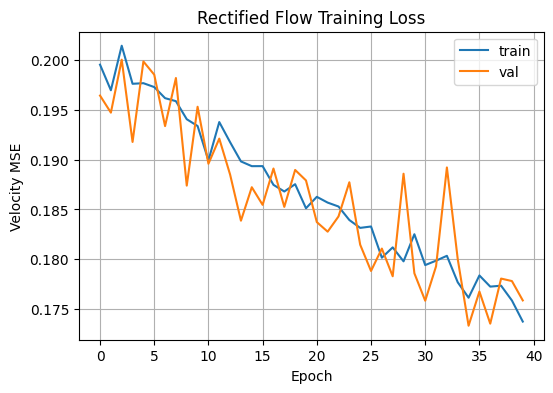

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_losses_hist, label="train")
plt.plot(val_losses_hist, label="val")
plt.xlabel("Epoch")
plt.ylabel("Velocity MSE")
plt.title("Rectified Flow Training Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import librosa

def postprocess_waveform(y, sr=16000):
    """
    Simple post-processing:
    1. HPSS: keep the harmonic component, remove some narrow-band noise
    2. Optionally apply a light low-pass filter
    """
    # HPSS
    y_harm, y_perc = librosa.effects.hpss(y)

    # Use only the harmonic part for now
    y_out = y_harm

    return y_out

In [ ]:
y_gen_rf_raw  = mel_db_to_audio(gen_mel_db_denoised, sr=sr, n_iter=256, momentum=0.9, smooth_sigma=None)
y_gen_rf_post = postprocess_waveform(y_gen_rf_raw, sr=sr)

In [ ]:
import numpy as np
import librosa

def segment_audio(y, sr, win_dur=0.5, hop_dur=0.25):
    """
    Split a long audio clip into a sequence of windows.
    win_dur: length of each segment (seconds)
    hop_dur: hop size (seconds)

    Returns:
        segments: list of shape [num_segs, win_len]
        starts:   starting sample index of each segment in the original waveform
    """
    win_len = int(sr * win_dur)
    hop_len = int(sr * hop_dur)

    segments = []
    starts = []

    n = len(y)
    pos = 0
    while pos < n:
        end = pos + win_len
        if end <= n:
            seg = y[pos:end]
        else:
            # Pad the last segment with zeros if it's shorter than win_len
            seg = np.pad(y[pos:], (0, end - n))
        segments.append(seg.astype(np.float32))
        starts.append(pos)

        if end >= n:
            break
        pos += hop_len

    return segments, np.array(starts)

In [ ]:
def estimate_pitch_midi(y_seg, sr,
                        fmin=librosa.note_to_hz("C2"),
                        fmax=librosa.note_to_hz("C7")):
    """
    Use librosa.yin to roughly estimate the fundamental frequency (f0) of a segment,
    then convert it to MIDI pitch.
    """
    f0 = librosa.yin(y_seg, fmin=fmin, fmax=fmax, sr=sr)
    f0 = f0[~np.isnan(f0)]
    if len(f0) == 0:
        return 60.0  # If nothing is detected, return a middle value (C4)

    f0_med = np.median(f0)
    midi = float(librosa.hz_to_midi(f0_med))
    midi = float(np.clip(midi, 0, 127))
    return midi

def compute_rms(segments):
    """
    Compute the RMS for each segment, and also return the maximum RMS
    for normalizing into 'velocity'.
    """
    rms_list = []
    for seg in segments:
        rms = float(np.sqrt(np.mean(seg**2) + 1e-8))
        rms_list.append(rms)
    max_rms = max(rms_list) if len(rms_list) > 0 else 1.0
    return rms_list, max_rms

In [ ]:
import soundfile as sf
import torch

def convert_violin_wav_to_trumpet(
    model,
    inst2id,
    src_wav_path,
    src_inst_name,
    tgt_inst_name,
    out_wav_path,
    win_dur=0.5,
    hop_dur=0.25,
    n_steps=100,
    mel_floor_db=-75.0,
    time_sigma=1.0,
    freq_sigma=0.8,
    device=device,
):
    # 1) Load original violin audio
    y_src, _ = librosa.load(src_wav_path, sr=sr)
    print(f"Source audio length: {len(y_src) / sr:.2f} seconds")

    # 2) Split into a sequence of 0.5s segments
    segments, starts = segment_audio(y_src, sr, win_dur=win_dur, hop_dur=hop_dur)
    rms_list, max_rms = compute_rms(segments)

    print(f"Total number of segments: {len(segments)}")

    win_len = int(sr * win_dur)
    hop_len = int(sr * hop_dur)

    # 3) Prepare output buffer + weights (for overlap-add)
    out_len = (len(segments) - 1) * hop_len + win_len
    out = np.zeros(out_len, dtype=np.float32)
    weight = np.zeros(out_len, dtype=np.float32)
    hann_win = np.hanning(win_len).astype(np.float32)

    # Instrument IDs (batch=1, so we can fix them directly)
    src_inst_id = torch.tensor([inst2id[src_inst_name]], dtype=torch.long, device=device)
    tgt_inst_id = torch.tensor([inst2id[tgt_inst_name]], dtype=torch.long, device=device)

    model.eval()

    for i, (seg, start) in enumerate(zip(segments, starts)):
        # ===== Estimate pitch / velocity conditioning =====
        pitch_midi = estimate_pitch_midi(seg, sr)
        pitch_norm = pitch_midi / 127.0

        rms = rms_list[i]
        vel_norm = rms / max_rms if max_rms > 1e-8 else 0.5
        vel_norm = min(vel_norm * 1.3, 1.0)

        # ===== Extract src mel (exactly the same audio_to_mel_db as in training) =====
        mel_src_db = audio_to_mel_db(seg, sr=sr)  # (128, 63)

        # Standardize
        mel_src_norm = (mel_src_db - mel_mean) / (mel_std + 1e-8)
        src_tensor = torch.from_numpy(mel_src_norm).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]

        pitch_t = torch.tensor([pitch_norm], dtype=torch.float32, device=device)
        vel_t   = torch.tensor([vel_norm],   dtype=torch.float32, device=device)

        # ===== RF sampling to generate target mel =====
        with torch.no_grad():
            gen_norm = sample_rectified_flow_heun(
                model,
                src_tensor,
                pitch_t,
                vel_t,
                src_inst_id,
                tgt_inst_id,
                n_steps=n_steps,
                device=device,
            )
        gen_norm = gen_norm[0, 0].cpu().numpy()                 # (128, 63)
        gen_mel_db = gen_norm * mel_std + mel_mean              # De-standardize

        # ===== Denoise in mel domain (tunable) =====
        gen_mel_db = denoise_mel_db(
            gen_mel_db,
            floor_db=mel_floor_db,
            time_sigma=time_sigma,
            freq_sigma=freq_sigma,
        )

        # 3) Brighten and boost high frequencies to make the sound “sharper”
        gen_mel_db = brighten_mel_db(
            gen_mel_db,
            bright_gain_db=6.0,     # Try 6 dB first
            high_start_ratio=0.35,  # Start brightening from roughly the top 65% of mel bands
            low_cut_ratio=0.1,      # Slight low-frequency reduction in the bottom 10%
            low_cut_db=3.0,
            floor_db=-80.0,
        )

        # ===== mel -> audio, obtain trumpet waveform for this segment =====
        y_seg_tgt = mel_db_to_audio(
            gen_mel_db,
            sr=sr,
            n_iter=128,
            momentum=0.9,
            smooth_sigma=None,
        )

        # Truncate / pad to fixed win_len
        if len(y_seg_tgt) < win_len:
            y_seg_tgt = np.pad(y_seg_tgt, (0, win_len - len(y_seg_tgt)))
        else:
            y_seg_tgt = y_seg_tgt[:win_len]

        # ===== Overlap-add to reconstruct the full signal =====
        yw = y_seg_tgt * hann_win
        s = start
        e = start + win_len
        out[s:e] += yw
        weight[s:e] += hann_win

        if (i + 1) % 10 == 0 or i == len(segments) - 1:
            print(f"Processed {i+1}/{len(segments)} segments")

    # Avoid division by zero
    mask = weight > 1e-6
    out[mask] /= weight[mask]

    # Save result
    sf.write(out_wav_path, out, sr)
    print(f"Conversion done, saved to: {out_wav_path}")

    return out


In [ ]:
src_wav_path = "clip3.wav"      # The violin clip you want to convert
out_wav_path = "violin_to_trumpet.wav"

src_inst_name = "string_acoustic_049"       # Replace with the violin instrument name in your dataset
tgt_inst_name = "brass_acoustic_038"        # Replace with the trumpet instrument name in your dataset

y_out = convert_violin_wav_to_trumpet(
    model,
    inst2id,
    src_wav_path,
    src_inst_name,
    tgt_inst_name,
    out_wav_path,
    win_dur=0.5,
    hop_dur=0.25,
    n_steps=100,
    mel_floor_db=-75.0,
    time_sigma=1.0,
    freq_sigma=0.8,
    device=device,
)

# Listen directly in the notebook:
from IPython.display import Audio, display
display(Audio(y_out, rate=sr))


Source audio length: 8.32 seconds
Total number of segments: 33
Processed 10/33 segments
Processed 20/33 segments
Processed 30/33 segments
Processed 33/33 segments
Conversion done, saved to: violin_to_trumpet.wav
